#  FOM ~ $O(m)$

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle

In [37]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [38]:
def sine_wave(amp,width,nx,dx,x):
    
    u0 = np.zeros(nx) + 1.0
    u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    
    return u0

In [40]:
def residual(un,uw,c,idxn1):
    
    # r = -u^{n} + u^{n+1} -dt*f(u^{n+1})
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r = -un + uw + f
    
    return r

In [41]:
def jacobian(u,c,idxn1):

    # J = I - dt*dfdu
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    subdiag_comp = np.ones(nx-1)
    subdiag_comp[:-1] = -c*u[1:]
        
    data = np.array([diag_comp, subdiag_comp])
    J = spdiags(data,[0,-1],nx-1,nx-1,format='csr')
    J[0,-1] = -c*u[0]
    
    return J

#     diag_comp = 1.0 + c*(2*u - u[idxn1])
#     subdiag_comp = -c*u
    
#     J = np.diag(diag_comp,0)
#     J[dn1] = subdiag_comp[1:]
#     J[0,-1] = -c*u[0]
    
#     return J

In [42]:
# predictive case
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-8
maxk = 10

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501  
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

u0 = sine_wave(amp,width,nx,dx,x)

dn1=kth_diag_indices(np.eye(nx-1),-1)
idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

In [43]:
t_total_start = time.time()

u = np.zeros((nt,nx))
u[0] = u0
I = sp.eye(nx,format='csr')
for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    uw = u[n,:-1].copy()
    
    r = residual(u[n,:-1],uw,c,idxn1)
    
    for k in range(maxk):
        J = jacobian(uw,c,idxn1)
        
        duw = spsolve(J, -r)
#         duw = np.linalg.solve(J,-r)
        
        uw = uw + duw
        
        r = residual(u[n,:-1],uw,c,idxn1)

        R = np.linalg.norm(r)
#         print(k,"th Newton iteration", "R:", R)
        if R < convergence_threshold:
            u[n+1,:-1] = uw.copy()
            u[n+1,-1] = u[n+1,0]
            break
    if R >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break
    
#     u[n+1,:-1] = uw.copy()
#     u[n+1,-1] = u[n+1,0]
            
t_total = time.time()-t_total_start
print()
print("Time elapsed: {} sec".format(t_total))


Time elapsed: 1.0732948780059814 sec


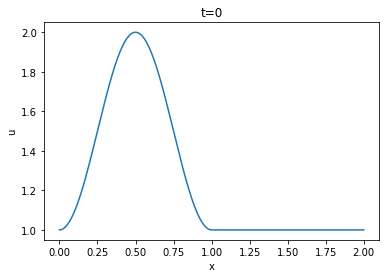

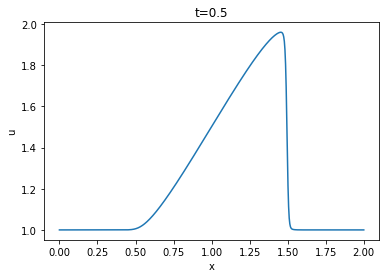

In [44]:
plt.figure()
plt.plot(x,u[0])
plt.xlabel('x')
plt.ylabel('u')
plt.title('t={}'.format(0))
plt.show()

plt.figure()
plt.plot(x,u[-1])
plt.xlabel('x')
plt.ylabel('u')
plt.title('t={}'.format(0.5))
plt.show()

# NM-ROM (g) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)+O(fm^2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io as sio


In [46]:
# load models
file_name_AE="./model/AE_v2_swish.p"
try:
    AE = pickle.load(open(file_name_AE,'rb'))
    
    en_w1=AE['en_w1']
    en_b1=AE['en_b1']
    en_w2=AE['en_w2']
    de_w1=AE['de_w1']
    de_w2=AE['de_w2']
    de_w1T=AE['de_w1T']
    de_w2T=AE['de_w2T']
    de_w2_sp=AE['de_w2_sp']
    de_w2T_sp=AE['de_w2T_sp']
    
    m, M2 = de_w2.shape
    f = de_w1.shape[1]

    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [47]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_np_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)  
    return y

def decoder_np_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = dout.dot(de_w2T)   
    return y,dydxT.T

def decoder_sp_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)
    return y

def decoder_sp_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
    return y,dydxT.T

In [48]:
# # for test only
# import autograd.numpy as anp
# from autograd import jacobian

# def sigmoid_anp(input):
#     return (1.0/(1.0+anp.exp(-input))).astype('float32')

# def decoder_anp(x): 
#     z1=anp.dot(x,de_w1T)
#     s1=sigmoid_anp(z1)
#     a1=z1*s1
#     y=anp.dot(a1,de_w2T)  
#     return y

# def jacobian_anp(x):
#     return jacobian(decoder_anp)(x)

# def decoder_anp_forward_backward(x):
#     y = decoder_anp(x)
#     dydx = jacobian_anp(x)
#     return y, dydx

# # test
# x_test=np.random.uniform(0,1,size=(f,)).astype('float32')

# y_anp,J_anp=decoder_anp_forward_backward(x_test)
# y_np,J_np=decoder_np_forward_backward(x_test)
# y_sp,J_sp=decoder_sp_forward_backward(x_test)

# print(np.max(y_anp-y_np),np.min(y_anp-y_np),np.max(J_anp-J_np),np.min(J_anp-J_np))
# print(np.max(y_anp-y_sp),np.min(y_anp-y_sp),np.max(J_anp-J_sp),np.min(J_anp-J_sp))

0.0 0.0 5.9604645e-08 -3.7252903e-08
4.4703484e-08 -2.9802322e-08 3.7252903e-08 -2.9802322e-08


In [51]:
def sine_wave(amp,width,nx,dx,x):
    
    u0 = np.zeros(nx) + 1.0
    u0[1:int(width/dx+1)] = 1.0 + amp/2*(np.sin(2*np.pi/(x[int(width/dx+1)]-x[1])*x[1:int(width/dx+1)]-np.pi/2)+1)
    u0[-1] = u0[0]
    
    return u0

In [52]:
def residual_hat(u_hatn,u_hatw,uw,c,Jg_pinv,idxn1):
    
    # \hat r = -\hat u^n + \hat u^{n+1} - dt*J_g^{\dagger}f(g(\hat u^{n+1}))   
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r_hat = -u_hatn + u_hatw + Jg_pinv.dot(f)
    
    return r_hat

In [53]:
I_hat = np.eye(f,dtype='float32')
def jacobian_hat(u,c,Jg_pinv,Jg,idxn1):
    
    # \hat J = \hat I - dtJg+JfJg
    
    diag_comp = c*(2*u - u[idxn1])
    diag_out = (diag_comp*Jg.T).T
    
    subdiag_comp = -c*u[1:]
    subdiag_out = (subdiag_comp*Jg[:-1].T).T
    
    top_row = -c*u[0]*Jg[-1]
    
    JfJg = diag_out
    JfJg[1:] += subdiag_out
    JfJg[0] += top_row

    J_hat = I_hat + (Jg_pinv@JfJg)
    
    return J_hat

In [73]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-5
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501  
dt = 0.5 / (nt - 1)   

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1 = np.zeros(nx-1,dtype='int')
idxn1[1:] = np.arange(nx-2)
idxn1[0] = nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0 = np.zeros(f,dtype='float32')

In [74]:
t_total_rom_g_start=time.time()

u_rom_g = np.zeros((nt,nx),dtype='float32')
u_rom_g[0] = u0.astype('float32')
u_hat = np.zeros((nt,f),dtype='float32')
u_hat[0] = u_hat0
I_hat = np.eye(f,dtype='float32')
for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    u_hatw = u_hat[n].copy()
    
    uw, Jg = decoder_sp_forward_backward(u_hatw)
    uw += u0[:-1]
    
    Jg_pinv = np.linalg.pinv(Jg)
    r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)
    
    for k in range(maxk):   
        J_hat = jacobian_hat(uw,c,Jg_pinv,Jg,idxn1)
        
        du_hatw = np.linalg.solve(J_hat,-r_hat) 
        u_hatw = u_hatw + du_hatw
        
        uw, Jg = decoder_sp_forward_backward(u_hatw)
        uw += u0[:-1]
        
        Jg_pinv = np.linalg.pinv(Jg)
        r_hat = residual_hat(u_hat[n],u_hatw,uw,c,Jg_pinv,idxn1)
        
        res = np.linalg.norm(r_hat)
        
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_g[n+1,:-1] = uw.copy()
            u_rom_g[n+1,-1] = u_rom_g[n+1,0]
            break
        
    if res >= convergence_threshold:
#         print("\n non converged after {}th iteration".format(maxk))
        break
        
#     u_hat[n+1] = u_hatw.copy()
#     u_rom_g[n+1,:-1] = uw.copy()
#     u_rom_g[n+1,-1] = u_rom_g[n+1,0]

t_total_rom_g=time.time()-t_total_rom_g_start
print()
print("Time elapsed: {} sec".format(t_total_rom_g))


Time elapsed: 1.488067865371704 sec


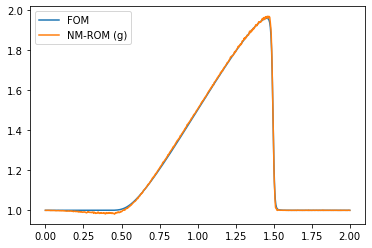

In [78]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_g[ts])
plt.legend(['FOM','NM-ROM (g)'])
plt.show()

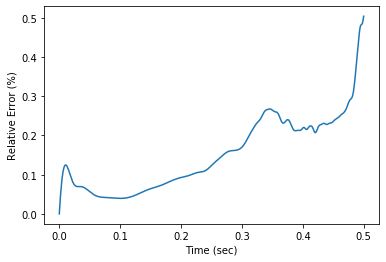

average relative error: 0.1785963101319689%

maximum relative error: 0.5040032695990075%


In [79]:
rel_err=np.linalg.norm(u-u_rom_g,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [80]:
# speed-up
speed_up=t_total/t_total_rom_g
print("speed-up: {}".format(speed_up))

speed-up: 0.7212674253521921


# NM-ROM (lspg) ~ $O(fmM_2)$, where $M_2$ is the number of nodes in a hidden layer of a fully dense decoder

# If a masked decoder, $O(fM_2)$, where $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [84]:
def residual_lspg(uwn,uw,c,idxn1):
    
    f = c*(uw**2 - uw*uw[idxn1])
    
    r = -uwn + uw + f
    
    return r

In [85]:
def jacobian_lspg(u,c,Jg,idxn1):
    
    # J \approx J_g - \Delta t J_f J_g = (I-\delta t J_f)J_g
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    diag_out = (diag_comp*Jg.T).T
    
    subdiag_comp = -c*u[1:]
    subdiag_out = (subdiag_comp*Jg[:-1].T).T
    
    top_row = -c*u[0]*Jg[-1]
    
    J = diag_out
    J[1:] += subdiag_out
    J[0] += top_row
    
    return J

In [104]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-5
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501 
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0 = np.zeros(f,dtype='float32')

In [105]:
t_total_rom_lspg_start=time.time()

u_rom_lspg = np.zeros((nt,nx),dtype='float32')
u_rom_lspg[0] = u0.astype('float32')
u_hat = np.zeros((nt,f),dtype='float32')
u_hat[0] = u_hat0
I_hat = np.eye(f,dtype='float32')
for n in range(nt-1): 
    print("")
    print(n,"th time step:")
    u_hatw = u_hat[n].copy()
    
    uw, Jg = decoder_sp_forward_backward(u_hatw)
    uw += u0[:-1]
    
    J_lspg = jacobian_lspg(uw,c,Jg,idxn1)
        
    r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
    r = r_lspg.dot(J_lspg)
    
    for k in range(maxk):   
        J = J_lspg.T.dot(J_lspg)
        
        du_hatw = np.linalg.solve(J,-r)
        
        u_hatw = u_hatw + du_hatw
        
        uw, Jg = decoder_sp_forward_backward(u_hatw)        
        uw += u0[:-1]
        
        J_lspg = jacobian_lspg(uw,c,Jg,idxn1)
    
        r_lspg = residual_lspg(u_rom_lspg[n,:-1],uw,c,idxn1)
        r = r_lspg.dot(J_lspg)
        
        res = np.linalg.norm(r)
        print(k,"th Newton iteration", "res:", "{:.8e}".format(res))
        
        if res < convergence_threshold:            
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg[n+1,:-1] = uw.copy()
            u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]
            break
            
    if res >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break
        
#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg[n+1,:-1] = uw.copy()
#     u_rom_lspg[n+1,-1] = u_rom_lspg[n+1,0]

t_total_rom_lspg=time.time()-t_total_rom_lspg_start
print()
print("Time elapsed: {} sec".format(t_total_rom_lspg))


0 th time step:
0 th Newton iteration res: 2.89972901e-04
1 th Newton iteration res: 3.28267197e-06

1 th time step:
0 th Newton iteration res: 3.11183219e-04
1 th Newton iteration res: 3.94870858e-06

2 th time step:
0 th Newton iteration res: 3.33754695e-04
1 th Newton iteration res: 4.52630275e-06

3 th time step:
0 th Newton iteration res: 3.55060387e-04
1 th Newton iteration res: 4.88215119e-06

4 th time step:
0 th Newton iteration res: 3.73117946e-04
1 th Newton iteration res: 4.74742274e-06

5 th time step:
0 th Newton iteration res: 3.85912688e-04
1 th Newton iteration res: 4.26529914e-06

6 th time step:
0 th Newton iteration res: 3.93109018e-04
1 th Newton iteration res: 3.73938951e-06

7 th time step:
0 th Newton iteration res: 3.94141127e-04
1 th Newton iteration res: 2.89762988e-06

8 th time step:
0 th Newton iteration res: 3.88840941e-04
1 th Newton iteration res: 2.40501868e-06

9 th time step:
0 th Newton iteration res: 3.78520199e-04
1 th Newton iteration res: 1.775

0 th Newton iteration res: 1.66324098e-04
1 th Newton iteration res: 4.20101429e-07

107 th time step:
0 th Newton iteration res: 1.66870246e-04
1 th Newton iteration res: 3.51082463e-07

108 th time step:
0 th Newton iteration res: 1.67705322e-04
1 th Newton iteration res: 2.66859786e-07

109 th time step:
0 th Newton iteration res: 1.68371902e-04
1 th Newton iteration res: 3.49824717e-07

110 th time step:
0 th Newton iteration res: 1.68916362e-04
1 th Newton iteration res: 3.92384862e-07

111 th time step:
0 th Newton iteration res: 1.69047809e-04
1 th Newton iteration res: 4.52288958e-07

112 th time step:
0 th Newton iteration res: 1.69571169e-04
1 th Newton iteration res: 1.37464752e-07

113 th time step:
0 th Newton iteration res: 1.69903738e-04
1 th Newton iteration res: 4.54155895e-07

114 th time step:
0 th Newton iteration res: 1.70059895e-04
1 th Newton iteration res: 1.97136657e-07

115 th time step:
0 th Newton iteration res: 1.70215630e-04
1 th Newton iteration res: 4.56

0 th Newton iteration res: 2.29218116e-04
1 th Newton iteration res: 2.56768828e-07

229 th time step:
0 th Newton iteration res: 2.34081308e-04
1 th Newton iteration res: 3.51634867e-07

230 th time step:
0 th Newton iteration res: 2.39017783e-04
1 th Newton iteration res: 2.27859772e-07

231 th time step:
0 th Newton iteration res: 2.43962320e-04
1 th Newton iteration res: 5.15786098e-07

232 th time step:
0 th Newton iteration res: 2.49001605e-04
1 th Newton iteration res: 3.45807337e-07

233 th time step:
0 th Newton iteration res: 2.54210987e-04
1 th Newton iteration res: 3.66864924e-07

234 th time step:
0 th Newton iteration res: 2.58927903e-04
1 th Newton iteration res: 2.37539965e-07

235 th time step:
0 th Newton iteration res: 2.63661437e-04
1 th Newton iteration res: 4.48528567e-07

236 th time step:
0 th Newton iteration res: 2.68668198e-04
1 th Newton iteration res: 5.11161318e-07

237 th time step:
0 th Newton iteration res: 2.73365353e-04
1 th Newton iteration res: 2.92


350 th time step:
0 th Newton iteration res: 6.75457588e-04
1 th Newton iteration res: 2.11785709e-06

351 th time step:
0 th Newton iteration res: 7.00883393e-04
1 th Newton iteration res: 1.82700342e-06

352 th time step:
0 th Newton iteration res: 7.31734675e-04
1 th Newton iteration res: 1.54910936e-06

353 th time step:
0 th Newton iteration res: 7.66541867e-04
1 th Newton iteration res: 1.20873983e-06

354 th time step:
0 th Newton iteration res: 8.02278810e-04
1 th Newton iteration res: 1.12311614e-06

355 th time step:
0 th Newton iteration res: 8.35994200e-04
1 th Newton iteration res: 1.14610100e-06

356 th time step:
0 th Newton iteration res: 8.63891211e-04
1 th Newton iteration res: 1.65507822e-06

357 th time step:
0 th Newton iteration res: 8.82694847e-04
1 th Newton iteration res: 2.11705242e-06

358 th time step:
0 th Newton iteration res: 8.90307827e-04
1 th Newton iteration res: 2.35446601e-06

359 th time step:
0 th Newton iteration res: 8.87443137e-04
1 th Newton 

0 th Newton iteration res: 2.09224783e-03
1 th Newton iteration res: 2.17133766e-05
2 th Newton iteration res: 9.52963148e-07

492 th time step:
0 th Newton iteration res: 2.16286094e-03
1 th Newton iteration res: 2.36961769e-05
2 th Newton iteration res: 1.18564515e-06

493 th time step:
0 th Newton iteration res: 2.28909822e-03
1 th Newton iteration res: 2.39729907e-05
2 th Newton iteration res: 7.27315296e-07

494 th time step:
0 th Newton iteration res: 2.33285455e-03
1 th Newton iteration res: 2.04512744e-05
2 th Newton iteration res: 1.16485126e-06

495 th time step:
0 th Newton iteration res: 2.16225907e-03
1 th Newton iteration res: 1.13003534e-05
2 th Newton iteration res: 4.12386925e-07

496 th time step:
0 th Newton iteration res: 1.93581975e-03
1 th Newton iteration res: 3.53864561e-06

497 th time step:
0 th Newton iteration res: 1.89426984e-03
1 th Newton iteration res: 3.21984407e-06

498 th time step:
0 th Newton iteration res: 1.96584524e-03
1 th Newton iteration res: 

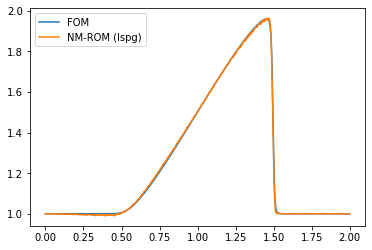

In [106]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_lspg[ts])
plt.legend(['FOM','NM-ROM (lspg)'])
plt.show()

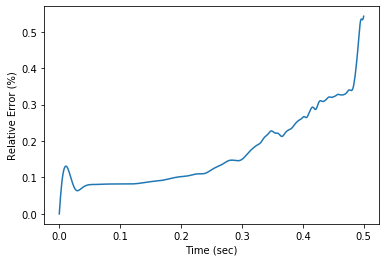

average relative error: 0.19718093595483221%

maximum relative error: 0.5425440285837764%


In [107]:
rel_err=np.linalg.norm(u-u_rom_lspg,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [108]:
# speed-up
speed_up=t_total/t_total_rom_lspg
print("speed-up: {}".format(speed_up))

speed-up: 0.6527411073816015


## Hyper reduction

In [111]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

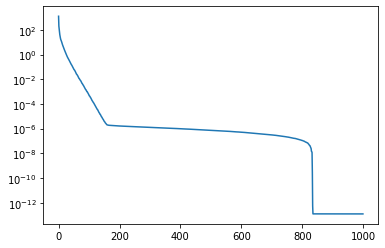

In [112]:
# load snapshot
snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
SVD={'Ur':Ur,'Sr':Sr,'VrT':VrT}
pickle.dump(SVD,open('./model/NMROM_residual_basis.p','wb'))
# SVD=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
Ur=SVD['Ur']
Sr=SVD['Sr']
plt.figure()
plt.semilogy(Sr)
plt.show()

In [113]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=31
DEIM_samples=47

acc=np.sum(Sr[:DEIM_basis]**2)/np.sum(Sr**2)*100
print(acc)
print(np.sum(Sr[:DEIM_basis])/np.sum(Sr)*100)

99.99991059303284
99.72581267356873


In [114]:
# precompute
phi_r=Ur[:,:DEIM_basis]
z=DEIM(phi_r,DEIM_samples)
ZT=np.eye(nx-1,dtype='float32')[z]
Z=ZT.T
precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
precomp=precomp1.T@precomp1

In [115]:
# influential indices
z_union=np.zeros((z.size,2),dtype='int')
for i in range(z.size):
    if z[i]==0:
        z_union[i,0]=0
        z_union[i,1]=nx-2
    else:
        z_union[i,0]=z[i]
        z_union[i,1]=z[i]-1        
z0=z_union[:,0]
z1=z_union[:,1]

z_union=np.unique(z_union.flatten())

z_union0_ind=np.zeros(z0.size,dtype='int')
z_union1_ind=np.zeros(z1.size,dtype='int')
for i in range(z0.size):
    z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
    z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

## Subnet

In [116]:
import torch
import torch.nn as nn

In [117]:
# Construct subnet
class DecoderFC(nn.Module):

    def __init__(self,):
        super(DecoderFC, self).__init__()
        self.fc1 = nn.Linear(f,M2,bias=False)
        self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = DecoderFC()

x_in=torch.ones(f)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
w1_mask=model.fc1.weight.grad
w2_mask=model.fc2.weight.grad

# subnet sparse weight
idx1=w1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_w1[i1,j1]
w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

idx2=w2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_w2[i2,j2]
w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(w1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(w2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

w1_sb_comp_dense=w1_sb_comp_sp.toarray()
w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
w2_sb_comp_dense=w2_sb_comp_sp.toarray()

w1_sb_comp_denseT=w1_sb_comp_dense.T
w2_sb_comp_denseT=w2_sb_comp_dense.T

# Using sparse matrix
w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_sb_np_forward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = w2_sb_comp_dense.dot(a1)  
    return y

def decoder_sb_np_forward_backward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = w2_sb_comp_dense.dot(a1) 

    dout = w1_sb_comp_denseT
    dout = (a1 + s1*(1-a1))*dout
    dydxT = dout.dot(w2_sb_comp_denseT)
    return y,dydxT.T

def decoder_sb_sp_forward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
    return y

def decoder_sb_sp_forward_backward(x):
    z1 = w1_sb_comp_dense.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

    dout = w1_sb_comp_denseT
    dout = (a1 + s1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
    return y,dydxT.T

In [118]:
# test
x_in=np.random.rand(f)
y_hr,dydx_hr=decoder_sb_np_forward_backward(x_in)
y,dydx=decoder_np_forward_backward(x_in)

print(np.max(y_hr-y[z_union]),np.min(y_hr-y[z_union]))
print(np.max(dydx_hr-dydx[z_union]),np.min(dydx_hr-dydx[z_union]))

2.7755575615628914e-17 -1.734723475976807e-17
5.932850044576554e-10 -8.950775537419631e-10


In [119]:
# dense vs sparse
%timeit decoder_np_forward(x_in)
%timeit decoder_sp_forward(x_in)
%timeit decoder_sb_np_forward_backward(x_in)
%timeit decoder_sb_sp_forward_backward(x_in)

33.4 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
218 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
402 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
215 µs ± 263 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Check sparsity of subnet

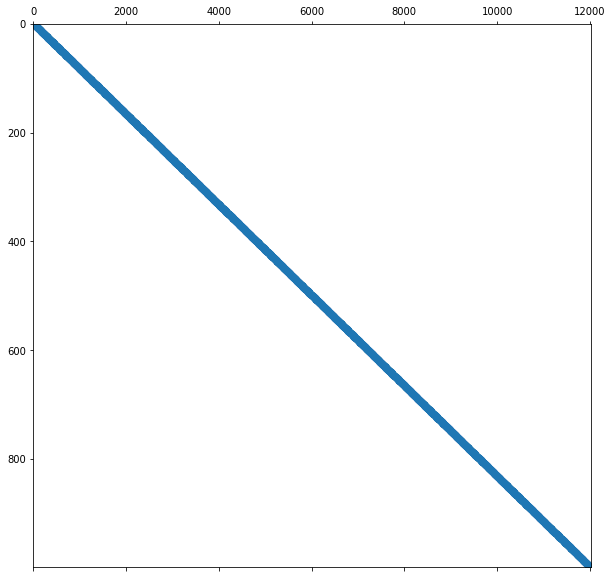

sparsity: 99.7005988023952


In [125]:
plt.figure(figsize=(10,10))
plt.spy(de_w2,marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(de_w2)[0].size/de_w2.size)*100)

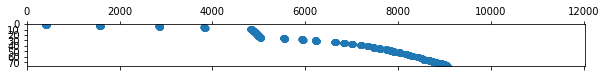

sparsity: 99.7005988023952


In [124]:
plt.figure(figsize=(10,10*z_union.size/de_w2.shape[0]))
plt.spy(de_w2[z_union],marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(de_w2[z_union])[0].size/de_w2[z_union].size)*100)

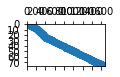

sparsity: 97.85714285714285


In [126]:
plt.figure(figsize=(10*w2_sb_comp_dense.shape[1]/de_w2.shape[1],10*w2_sb_comp_dense.shape[0]/de_w2.shape[0]))
plt.spy(w2_sb_comp_dense,marker='.',aspect='auto')
plt.show()
print('sparsity:',(1-np.nonzero(w2_sb_comp_dense)[0].size/w2_sb_comp_dense.size)*100)

## Efficient version ~ $O(f\frac{z}{m}M_2)+O(fz^2)$, where $z$ is the number of sampling points and $M_2$ is the number of nodes in a hidden layer of a masked decoder

In [127]:
def residual_lspg_hr(uwn_z,g,z0_ind,z1_ind,c):
    
    # g is subnet of g
    # Jg is subnet of Jg
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + g[z0_ind] + c*(g[z0_ind]**2 - g[z0_ind]*g[z1_ind])
    
    return r

def jacobian_lspg_hr(g,Jg,z0_ind,z1_ind,c):
    
    J = ((1.0 + c*(2*g[z0_ind] - g[z1_ind]))*Jg[z0_ind].T).T + (-c*g[z0_ind]*Jg[z1_ind].T).T
    
    return J

In [139]:
amp = 1.0
width = 1.0

convergence_threshold = 1.0e-5
maxk = 4

nx = 1001
dx = 2.0 / (nx - 1)
nt = 501 
dt = 0.5 / (nt - 1)  

c = dt/dx

x = np.linspace(0, 2, nx)

idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

u0 = sine_wave(amp,width,nx,dx,x)
u_hat0=np.zeros(f,dtype='float32')

In [140]:
t_total_rom_lspg_hr_start=time.time()

u_rom_lspg_hr = np.zeros((nt,nx),dtype='float32')
u_rom_lspg_hr[0] = u0.astype('float32')
u_hat = np.zeros((nt,f),dtype='float32')
u_hat[0] = u_hat0
I_hat = np.eye(f,dtype='float32')
for n in range(nt-1): 
#     print("")
#     print(n,"th time step:")
    
    u_hatw = u_hat[n].copy()
    
    uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
    uw += u0[z_union]
    
    J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
    J_lspgT = J_lspg.T
        
    r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
    r = J_lspgT.dot(precomp.dot(r_lspg))
    
    for k in range(maxk):   
        J = J_lspgT@precomp@J_lspg
        
        du_hatw = np.linalg.solve(J,-r)
        
        u_hatw = u_hatw + du_hatw
        
        uw, Jg = decoder_sb_sp_forward_backward(u_hatw)        
        uw += u0[z_union]
        
        J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T
    
        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))

        res = np.linalg.norm(r)
#         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

        if res < convergence_threshold:
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
            break
            
    if res >= convergence_threshold:
        print("\n non converged after {}th iteration".format(maxk))
        break

#     u_hat[n+1] = u_hatw.copy()
#     u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
#     u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

t_total_rom_lspg_hr=time.time()-t_total_rom_lspg_hr_start
print()
print("Time elapsed: {} sec".format(t_total_rom_lspg_hr))


Time elapsed: 0.5175938606262207 sec


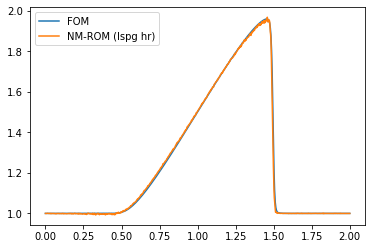

In [144]:
# plot
ts=-1

plt.figure()
plt.plot(x,u[ts],x,u_rom_lspg_hr[ts])
plt.legend(['FOM','NM-ROM (lspg hr)'])
plt.show()

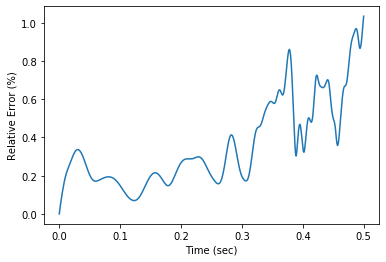

average relative error: 0.4231369106297713%

maximum relative error: 1.0344678402649343%


In [145]:
rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
max_rel_err = np.max(rel_err)  

plt.plot(dt*np.arange(nt),rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.show()

print("average relative error: {}%".format(avg_rel_err))
print()
print("maximum relative error: {}%".format(max_rel_err))

In [146]:
# speed-up
speed_up=t_total/t_total_rom_lspg_hr
print("speed-up: {}".format(speed_up))

speed-up: 2.0736236645222865


# Save data to mat file

In [134]:
from scipy.io import savemat, loadmat

In [135]:
savemat("./data/NMROM.mat",mdict={"u_rom_lspg_hr":u_rom_lspg_hr,"u":u})